<a href="https://colab.research.google.com/github/nicolascavalli/KaggleProjects/blob/main/MultipleDiseaseClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'multiple-disease-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4532617%2F7752217%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240317%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240317T140750Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3dcf983b49a41c193ee2c9d17d1db207280a35bcfc5394074e15505b27987870c4872c57746276504cb208b1ffced528e5fe87317622283960ceb1f648136261dd202f1a40d0ef3178e094c56b5b513be62d9776372538acb22be7433779938a63c7dcb06d255ad872ceb45db3c69f13edaf140c32ad1f2449b6148c5a210bb07391e227c0a8db9e422cc8a0c271b34bc06854dd79d5959b359b38bf1e990dc8122015e19a978298fcc7b7dee89b0d1382c07da516cc5e998ebb8fc4cf4a16e5d34a621e5f4f4909e0cd0e7aebab0b980013cac9d08a503d35dc201cbd3c358ebbc1d0a6e1e80944e866ea98bd03283d217ad80c896dcd323828236554f57428'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 292151 bytes downloaded
Downloaded and uncompressed: multiple-disease-prediction
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multiple-disease-prediction/Blood_samples_dataset_balanced_2(f).csv
/kaggle/input/multiple-disease-prediction/blood_samples_dataset_test.csv


### First Impressions on Dataset

In [15]:
df = pd.read_csv('/kaggle/input/multiple-disease-prediction/blood_samples_dataset_test.csv')
df.head()

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.001827,0.033693,0.114755,0.997927,0.562604,0.866499,0.578042,0.914615,0.026864,0.038641,...,0.653230,0.186104,0.430398,0.016678,0.885352,0.652733,0.788235,0.054788,0.031313,Thalasse
1,0.436679,0.972653,0.084998,0.180909,0.675736,0.563889,0.798382,0.670361,0.376092,0.184890,...,0.833540,0.153001,0.458533,0.401845,0.635969,0.574425,0.047025,0.607985,0.594123,Diabetes
2,0.545697,0.324815,0.584467,0.475748,0.558596,0.661007,0.934056,0.381782,0.500342,0.531829,...,0.678901,0.220479,0.817151,0.690981,0.101633,0.855740,0.551124,0.413294,0.070909,Heart Di
3,0.172994,0.050351,0.736000,0.782022,0.069435,0.085219,0.032907,0.460619,0.785448,0.491495,...,0.381500,0.459396,0.420154,0.798537,0.399236,0.324600,0.499504,0.436662,0.242766,Diabetes
4,0.758534,0.739968,0.597868,0.772683,0.875720,0.860265,0.486189,0.486686,0.621048,0.191756,...,0.993381,0.272338,0.663579,0.265227,0.918847,0.804910,0.571119,0.188368,0.750848,Heart Di


In [4]:
#Analysing data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Glucose                                    486 non-null    float64
 1   Cholesterol                                486 non-null    float64
 2   Hemoglobin                                 486 non-null    float64
 3   Platelets                                  486 non-null    float64
 4   White Blood Cells                          486 non-null    float64
 5   Red Blood Cells                            486 non-null    float64
 6   Hematocrit                                 486 non-null    float64
 7   Mean Corpuscular Volume                    486 non-null    float64
 8   Mean Corpuscular Hemoglobin                486 non-null    float64
 9   Mean Corpuscular Hemoglobin Concentration  486 non-null    float64
 10  Insulin                   

As you can see, there aren't missing values in dataset and all the atribbutes are float values.

In [5]:
#Verifying the shape
df.shape

(486, 25)

In [6]:
#Verifying if there's duplicate
df.drop_duplicates(inplace=True)
df.shape

(486, 25)

There aren't duplicates rows on dataset

### Exploratory Data Analysis

In [7]:
df.describe()

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,Triglycerides,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein
count,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,...,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000
mean,0.490044,0.506797,0.485502,0.528136,0.509783,0.504347,0.501042,0.516185,0.510145,0.501105,...,0.498538,0.489365,0.501706,0.487933,0.500615,0.499675,0.493794,0.515541,0.510077,0.517365
std,0.284196,0.282871,0.298818,0.292610,0.290887,0.302865,0.294501,0.279954,0.285213,0.290614,...,0.288848,0.290849,0.286729,0.292726,0.285374,0.301451,0.292400,0.287223,0.294011,0.291645
min,0.001827,0.003088,0.000719,0.000006,-0.000206,0.000552,0.004556,0.000309,-0.000614,0.000719,...,0.001885,-0.000991,0.001036,-0.000546,-0.000312,0.002047,0.002145,0.008831,0.005714,-0.000991
25%,0.236664,0.268021,0.201994,0.276155,0.264944,0.218573,0.246255,0.287755,0.259967,0.255839,...,0.238772,0.239302,0.262516,0.229095,0.251076,0.239369,0.228581,0.262924,0.267101,0.263192
50%,0.496471,0.502397,0.477706,0.538642,0.511102,0.518103,0.496275,0.533319,0.498332,0.493929,...,0.503164,0.481549,0.511373,0.481533,0.515321,0.497846,0.507581,0.526299,0.508479,0.546542
75%,0.727144,0.754638,0.750028,0.789486,0.767896,0.768466,0.761107,0.746765,0.761956,0.734817,...,0.749527,0.725472,0.756136,0.741867,0.739248,0.775458,0.751124,0.777839,0.781128,0.776940
max,0.991742,0.999606,0.997876,0.999507,0.999646,0.997267,1.000857,0.996362,0.999234,0.999666,...,0.999826,0.999265,0.999567,1.000744,1.000326,1.000402,0.999857,0.999348,1.000125,0.999488


Notice that there are some negative values in certain features. we need to normalize the dataset

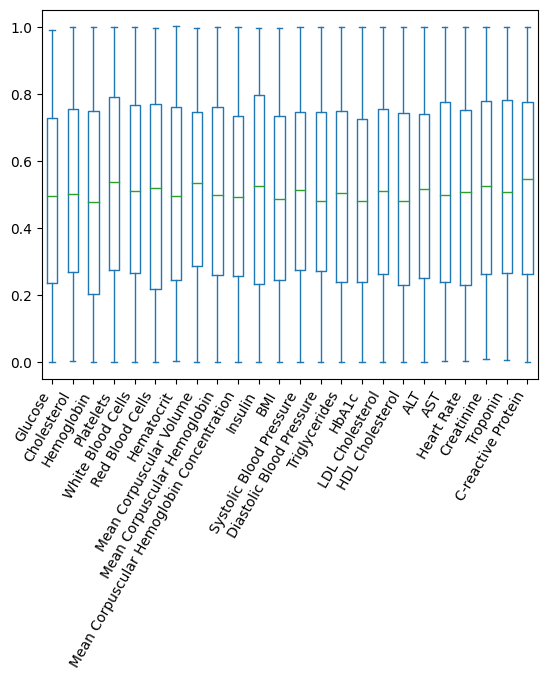

In [8]:
#Analysing the distribution
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

df.plot.box()
plt.xticks(rotation=60, ha='right');

It seems that there aren't outliers

In [9]:
#Analysing the distribution of the target feature
df['Disease'].value_counts(normalize=True)

Diabetes    0.604938
Anemia      0.172840
Thalasse    0.098765
Heart Di    0.080247
Thromboc    0.032922
Healthy     0.010288
Name: Disease, dtype: float64

In [10]:
#Applying LabelEncoder in the target to verify the correlation between features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Disease'] = le.fit_transform(df['Disease'])
df.head()

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.001827,0.033693,0.114755,0.997927,0.562604,0.866499,0.578042,0.914615,0.026864,0.038641,...,0.653230,0.186104,0.430398,0.016678,0.885352,0.652733,0.788235,0.054788,0.031313,4
1,0.436679,0.972653,0.084998,0.180909,0.675736,0.563889,0.798382,0.670361,0.376092,0.184890,...,0.833540,0.153001,0.458533,0.401845,0.635969,0.574425,0.047025,0.607985,0.594123,1
2,0.545697,0.324815,0.584467,0.475748,0.558596,0.661007,0.934056,0.381782,0.500342,0.531829,...,0.678901,0.220479,0.817151,0.690981,0.101633,0.855740,0.551124,0.413294,0.070909,3
3,0.172994,0.050351,0.736000,0.782022,0.069435,0.085219,0.032907,0.460619,0.785448,0.491495,...,0.381500,0.459396,0.420154,0.798537,0.399236,0.324600,0.499504,0.436662,0.242766,1
4,0.758534,0.739968,0.597868,0.772683,0.875720,0.860265,0.486189,0.486686,0.621048,0.191756,...,0.993381,0.272338,0.663579,0.265227,0.918847,0.804910,0.571119,0.188368,0.750848,3


<Axes: >

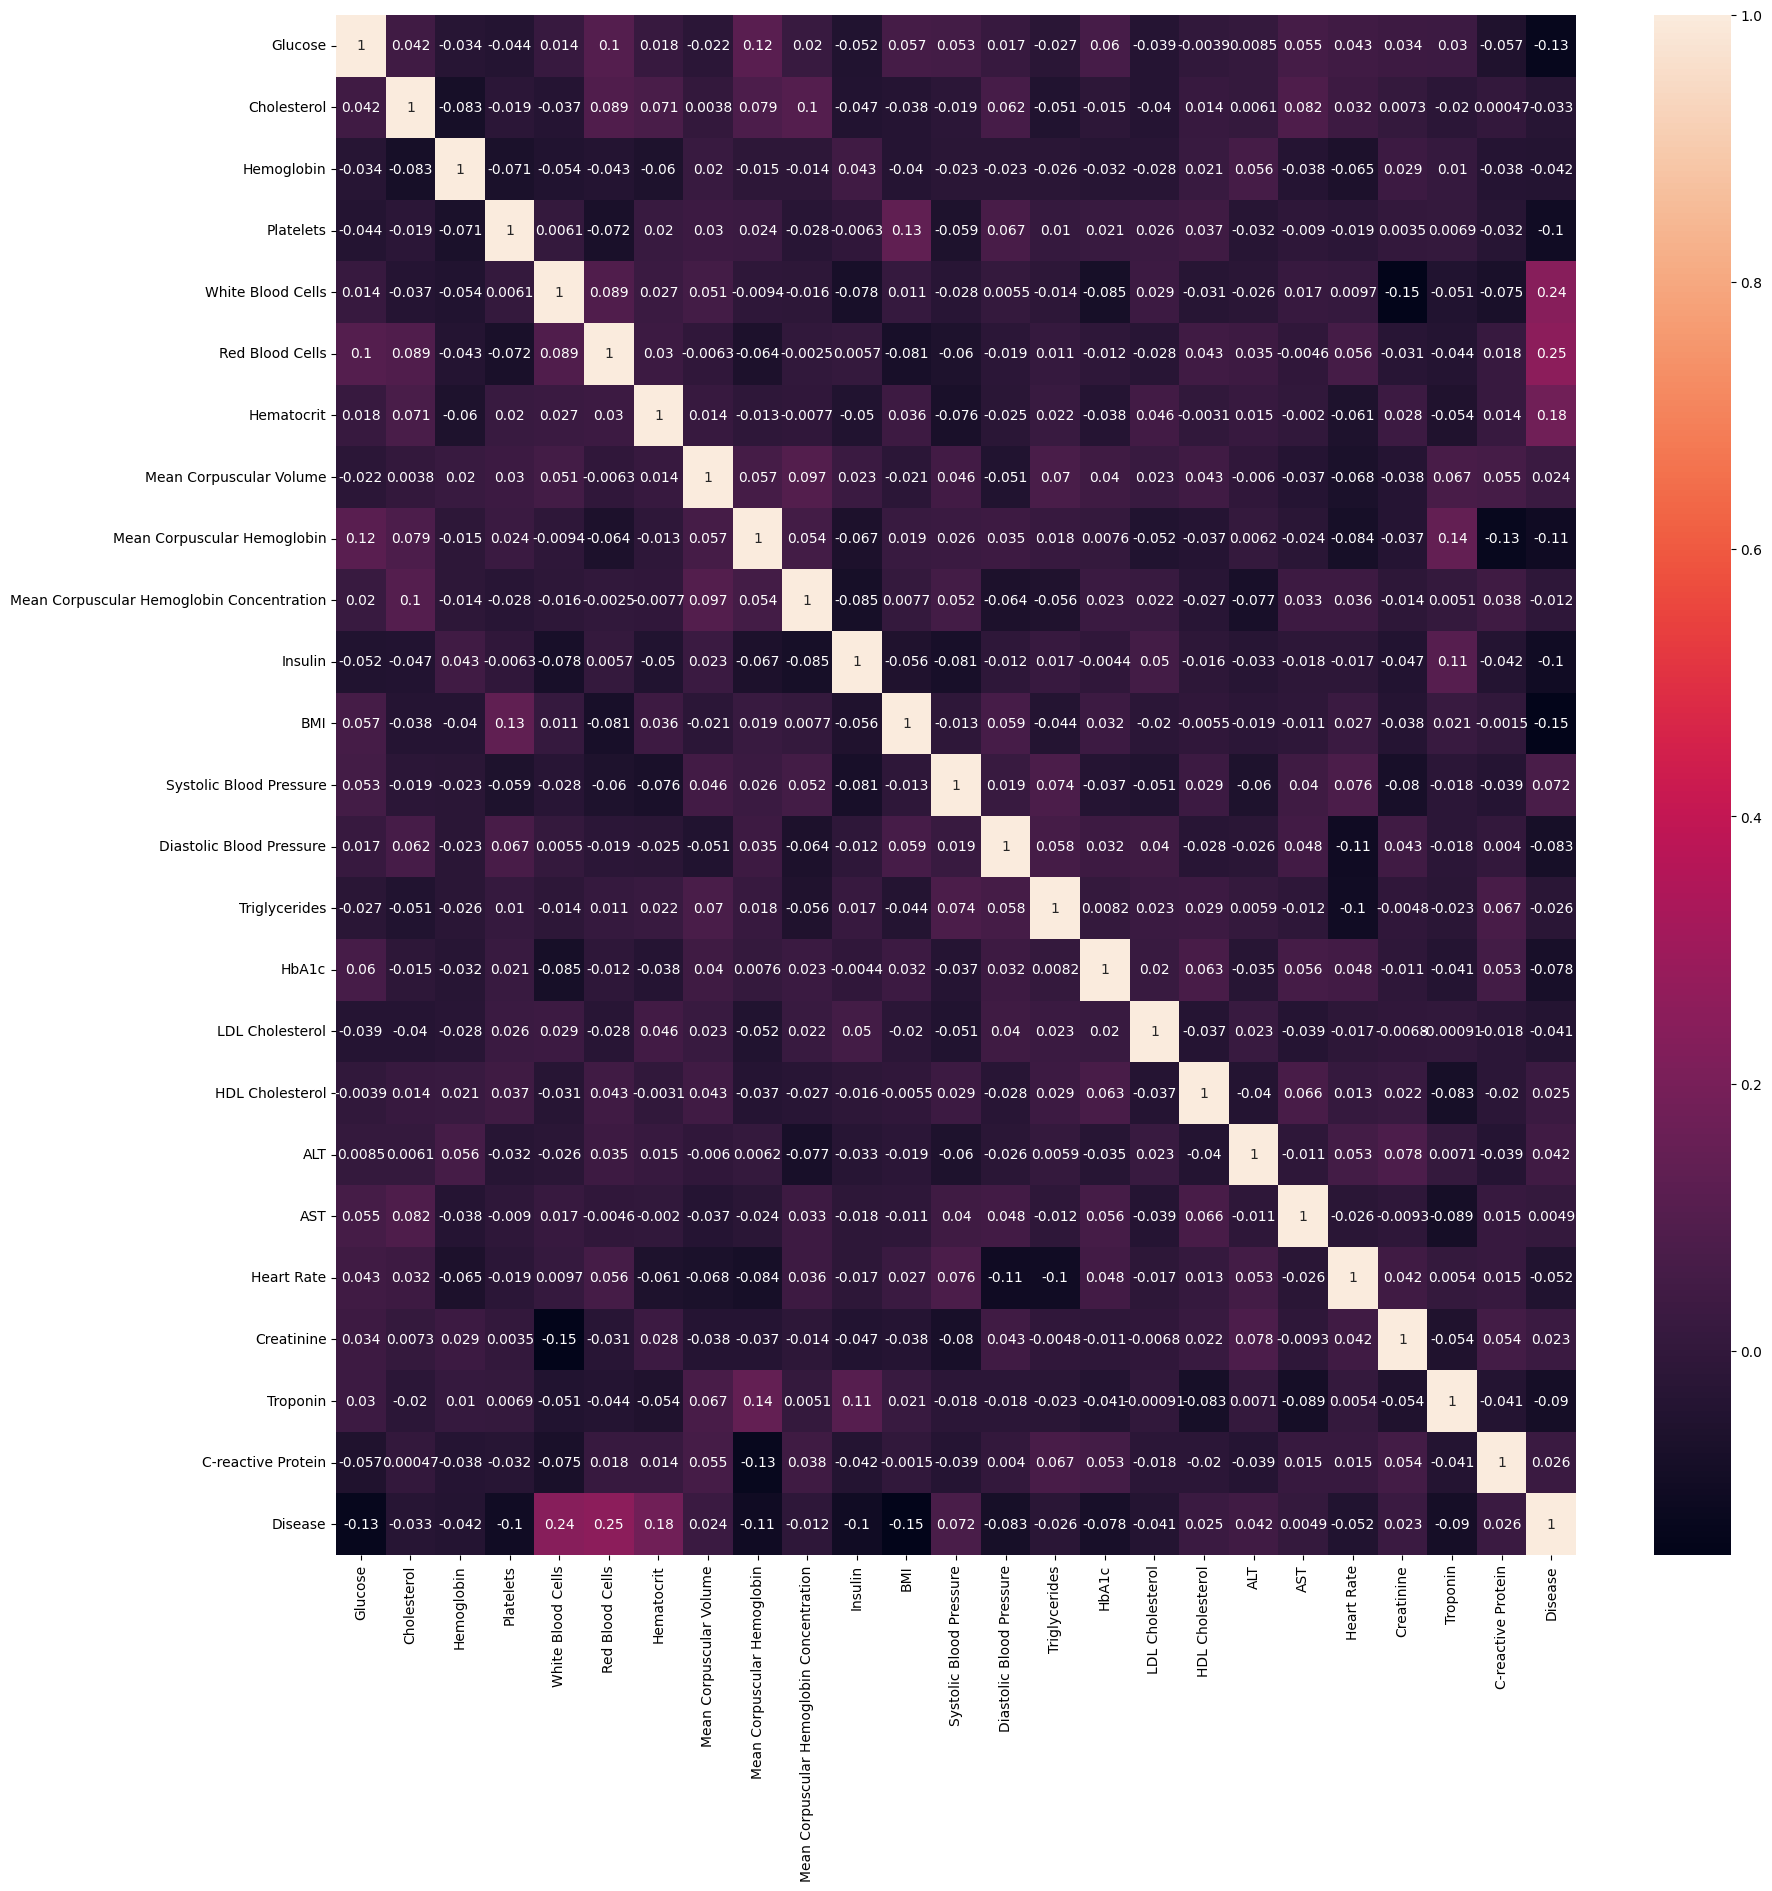

In [11]:
#Verifying the correlation
import seaborn as sns
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, ax=ax)

<Axes: xlabel='Glucose', ylabel='Troponin'>

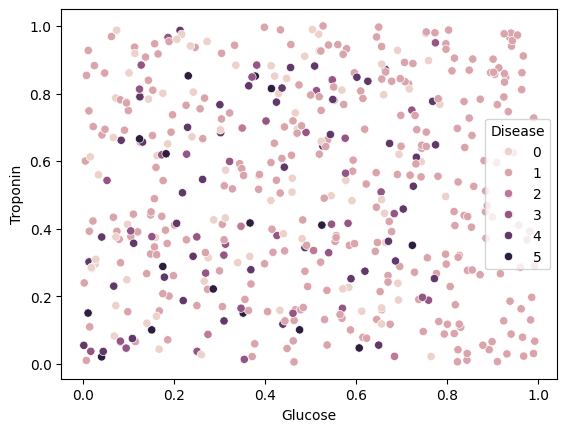

In [12]:
sns.scatterplot(data=df, x='Glucose', y='Troponin', hue='Disease')

<Axes: xlabel='Mean Corpuscular Volume', ylabel='Cholesterol'>

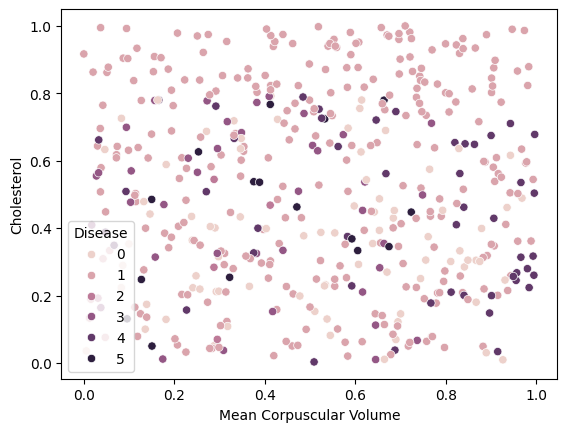

In [13]:
sns.scatterplot(data=df, x='Mean Corpuscular Volume', y='Cholesterol', hue='Disease')

In [16]:
#Normalize the dataset and split in atributtes and target

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X = pd.DataFrame(mms.fit_transform(df.drop(columns='Disease')), index=df.drop(columns='Disease').index, columns=df.drop(columns='Disease').columns)
X.head()


,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,Triglycerides,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein
0,0.000000,0.030712,0.114362,0.998419,0.562893,0.868800,0.575615,0.917929,0.027483,0.037962,...,0.970281,0.654053,0.185340,0.430389,0.016979,0.884760,0.652080,0.786866,0.049350,0.032289
1,0.439282,0.972952,0.084520,0.180993,0.676042,0.565193,0.796774,0.672707,0.376764,0.184365,...,0.516984,0.834317,0.152188,0.458488,0.401900,0.634967,0.573592,0.038559,0.605656,0.594829
2,0.549411,0.322851,0.585412,0.475980,0.558885,0.662632,0.932951,0.382985,0.501033,0.531670,...,0.520186,0.679718,0.219765,0.816644,0.690852,0.099750,0.855553,0.547485,0.409871,0.071866
3,0.172910,0.047428,0.737377,0.782407,0.069652,0.084947,0.028456,0.462134,0.786182,0.491294,...,0.944993,0.382393,0.459034,0.420159,0.798340,0.397843,0.323194,0.495370,0.433370,0.243640
4,0.764416,0.739454,0.598851,0.773063,0.876055,0.862546,0.483421,0.488304,0.621757,0.191238,...,0.081026,0.994118,0.271701,0.663270,0.265370,0.918310,0.804606,0.567671,0.183680,0.751479


In [17]:
#Splitting dataset in train and test
y = df['Disease']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [18]:
y

0      Thalasse
1      Diabetes
2      Heart Di
3      Diabetes
4      Heart Di
         ...   
481    Diabetes
482    Heart Di
483      Anemia
484    Diabetes
485    Diabetes
Name: Disease, Length: 486, dtype: object

### Modeling

#### Logistic Regression

In [19]:
#Fitting model to train dataset
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=500, multi_class='multinomial')
lr.fit(X_train, y_train)

LogisticRegression(max_iter=500, multi_class='multinomial')

In [20]:
#Predicting the test dataset
lr_pred = lr.predict(X_test)

In [21]:
#Verifying metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score

In [22]:
print(f'Accuracy: {accuracy_score(y_test, lr_pred)}')
print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, lr_pred)}')

Accuracy: 0.639344262295082
Balanced Accuracy: 0.372952380952381


#### Decision Tree Classifier

In [23]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)

In [26]:
print(f'Accuracy: {accuracy_score(y_test, dtc_pred)}')
print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, dtc_pred)}')



Accuracy: 0.9426229508196722
Balanced Accuracy: 0.8777142857142858


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


#### SVM

In [27]:
from sklearn.svm import SVC

In [28]:
svc = SVC()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

In [29]:
print(f'Accuracy: {accuracy_score(y_test, svc_pred)}')
print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, svc_pred)}')

Accuracy: 0.639344262295082
Balanced Accuracy: 0.2702857142857143


In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

In [32]:
print(f'Accuracy: {accuracy_score(y_test, rfc_pred)}')
print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, rfc_pred)}')

Accuracy: 0.8278688524590164
Balanced Accuracy: 0.6516190476190477


So, after testing several models, decision tree classifier is the one that performed better.